In [1]:
import glob
import io
import itertools
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy
import subprocess
import tempfile

import simtk.openmm.app as omm_app
import simtk.openmm as omm
from simtk.unit import *
from simtk.openmm.app.forcefield import PME, HBonds
import pdbfixer

import budeff
import isambard
import isambard.modelling as modelling

%matplotlib inline

In [2]:
def run_dfire2(assembly, path_to_lib_file, path_to_executable='calene'):
    """Returns the DFIRE2 score for the assembly.
    
    Parameters
    ----------
    assembly : ampal.Assembly
        Structure to be analysed.
    path_to_lib_file : str
        Path to lib file used by DFIRE.
    path_to_executable : str
        Path to the DFIRE executable.
    
    Returns
    -------
    dfire_score : float
        Score returned from DFIRE2.
    """

    alignments = {'all': '*', 'bb': 'n,ca,c,o', 'ca': 'ca'}

    with tempfile.NamedTemporaryFile() as pdb_file:
        pdb_file.write(assembly.pdb.encode())
        dfire_out = subprocess.check_output(
            [path_to_executable, path_to_lib_file, pdb_file.name]).decode()
        dfire_score = float(dfire_out.split()[-1])
    return dfire_score

In [3]:
def run_openmm_amber(assembly, minimize_energy=False):
    fixer = pdbfixer.PDBFixer(pdbfile=io.StringIO(assembly.pdb))
    fixer.findMissingResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    pdb = omm_app.Modeller(fixer.topology, fixer.positions)
    forcefield = omm_app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
    pdb.addHydrogens(forcefield)
    
    platform = omm.Platform.getPlatformByName('CPU')  # OpenCL works out the box on a Mac
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=omm_app.CutoffNonPeriodic)
    integrator = omm.LangevinIntegrator(298*kelvin, 1.0/picoseconds, 2.0*femtoseconds)
    simulation = omm_app.Simulation(pdb.topology, system, integrator, platform=platform)
    simulation.context.setPositions(pdb.positions)
    simulation.reporters.append(omm_app.PDBReporter('output.pdb', 1000))
    simulation.reporters.append(
        omm_app.StateDataReporter(
            sys.stdout, 1000,
            step=True, potentialEnergy=True, temperature=True
        )
    )
    if minimize_energy:
        simulation.minimizeEnergy()
    current_state = simulation.context.getState(getEnergy=True)
    energy = current_state.getKineticEnergy()
    return energy.value_in_unit(energy.unit)

In [4]:
all_structures = sorted(
    list(map(isambard.ampal.load_pdb, glob.glob('biological_units/*.pdb'))),
    key=lambda x: x.id
)

In [5]:
all_structures

[<Assembly (a_6_grp4PNB_bio_unit) containing 6 Polypeptides, 6 Ligands>,
 <Assembly (a_6_grp52_bio_unit) containing 6 Polypeptides, 12 Ligands>,
 <Assembly (a_7_grp51_bio_unit) containing 7 Polypeptides, 9 Ligands>,
 <Assembly (a_8_grp46_bio_unit) containing 8 Polypeptides, 16 Ligands>,
 <Assembly (b_5_4uot) containing 5 Polypeptides, 338 Ligands>,
 <Assembly (b_5_grp4PN8_bio_unit) containing 5 Polypeptides, 77 Ligands>,
 <Assembly (b_6_grp4PN9_bio_unit) containing 6 Polypeptides, 74 Ligands>,
 <Assembly (b_7_grp4PNA_bio_unit) containing 7 Polypeptides, 86 Ligands>,
 <Assembly (c_7_2hy6) containing 7 Polypeptides, 187 Ligands>,
 <Assembly (c_7_grp82_bio_unit) containing 7 Polypeptides, 1 Ligand>,
 <Assembly (cb_6_grp76_bio_unit) containing 6 Polypeptides, 5 Ligands>,
 <Assembly (d_6_grp23_bio_unit) containing 6 Polypeptides>,
 <Assembly (d_6_grp24_bio_unit) containing 6 Polypeptides, 4 Ligands>,
 <Assembly (d_6_grp73_bio_unit) containing 6 Polypeptides>,
 <Assembly (d_6_grp81_bio_unit)

In [6]:
for structure in all_structures:
    structure._molecules = structure.filter_mol_types('ligands')
    to_del = []
    for pp in structure:
        if pp[0].mol_code == 'GLY':
            del pp._monomers[0]
        if pp[-1].mol_code == 'GLY':
            if structure.id != 'c_7_2hy6':
                del pp._monomers[-1]
        pp.ligands = []

In [7]:
all_sequences = [x.sequences[0] for x in all_structures]

In [8]:
all_sequences

['EIAQSIKEIAKSIKEIAWSIKEIAQSIK',
 'EVAQAVKEVAKAVKEVAWAVKEVAQAVK',
 'EVAQAIKEVAKAIKEVAWAIKEVAQAIK',
 'EIAQAIKEIAKAIKEIAWAIKEIAQAIK',
 'TQEYLLKEIMKLLKEQIKLLKEQIKMLK',
 'KIEQILQKIEKILQKIEWILQKIEQILQ',
 'EIAKSLKEIAKSLKEIAWSLKEIAKSLK',
 'EIAQALKEIAKALKEIAWALKEIAQALK',
 'QLADAVEELASANYHLANAVARLAKAVG',
 'ELAQSIKELAKSIKEEAWSIKELAQSIK',
 'ELAQSIKELAKSIKELAWSIKELAQSIK',
 'ELAQALKELAKALKELAWALKELAQALK',
 'ELAQSLKELAKSLKELAWSLKELAQSLK',
 'ELAQALKELAKALKEQAWALKELAQALK',
 'ELAQALKELAKALKEEAWALKELAQALK',
 'EIAQAFKEIAKAFKEIAWAFKEIAQAFK',
 'EFAQALKEFAKALKEFAWALKEFAQALK']

In [9]:
all_sequences_all_structures = list(itertools.product(all_sequences, all_structures))

In [10]:
budeff.FORCE_FIELDS

{'bude_2016v1': <BUFF Force Field Object: bude_2016v1>,
 'bude_2015v1': <BUFF Force Field Object: bude_2015v1>}

In [11]:
def per_chain_scores(structure):
    total_scores = []
    steric_scores = []
    ff = budeff.FORCE_FIELDS['bude_2016v1']
    budeff.assign_force_field(structure, ff)
    for ref in structure:
        tar = isambard.ampal.Assembly()
        for hel in structure:
            if hel is not ref:
                tar.append(hel)
        interactions = budeff.find_inter_ampal([ref, tar], ff.distance_cutoff)
        score = budeff.score_interactions(interactions, ff)
        total_scores.append(score.total_energy)
        steric_scores.append(score.steric)
    defire_score = run_dfire2(
        structure,
        '/home/cw12401/software/dependencies_for_isambard/DFIRE2-pair/dfire_pair.lib',
        '/home/cw12401/software/dependencies_for_isambard/DFIRE2-pair/calene')
    defire_normalised = defire_score / len(structure)
    amber_score = run_openmm_amber(structure)
    amber_normalised = amber_score / len(structure)
    return total_scores, steric_scores, defire_normalised, amber_normalised

In [12]:
def proc_data(seq_str):
    sequence, structure = seq_str
    oligomeric_state = len(structure)
    structure = modelling.pack_side_chains_scwrl(structure, [sequence]*oligomeric_state)
    total_scores, steric_scores, defire_score, amber_score = per_chain_scores(structure)
    return (numpy.mean(steric_scores), numpy.std(steric_scores),
            numpy.mean(total_scores), numpy.std(total_scores),
            defire_score, amber_score)

In [13]:
with mp.Pool(8) as executor:
    results = executor.map(proc_data, all_sequences_all_structures)

In [14]:
steric_results, steric_std, total_results, total_std, defire_scores, amber_scores = zip(*results)
steric_results = numpy.reshape(
    steric_results,
    (int(numpy.sqrt(len(steric_results))), int(numpy.sqrt(len(steric_results)))))
steric_std = numpy.reshape(
    steric_std,
    (int(numpy.sqrt(len(steric_std))), int(numpy.sqrt(len(steric_std)))))
total_results = numpy.reshape(
    total_results,
    (int(numpy.sqrt(len(total_results))), int(numpy.sqrt(len(total_results)))))
total_std = numpy.reshape(
    total_std,
    (int(numpy.sqrt(len(total_std))), int(numpy.sqrt(len(total_std)))))
total_defire = numpy.reshape(
    defire_scores,
    (int(numpy.sqrt(len(defire_scores))), int(numpy.sqrt(len(defire_scores)))))
total_amber = numpy.reshape(
    amber_scores,
    (int(numpy.sqrt(len(amber_scores))), int(numpy.sqrt(len(amber_scores)))))

In [15]:
def plot_im(array, savename=None, labels=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(array, interpolation='nearest', cmap='seismic', vmin=vmin, vmax=vmax)
    ax.set_xticks(numpy.arange(0, len(all_sequences), 1.0))
    if labels == None:
        ax.set_xticklabels(
            [seq[4:10] for seq in all_sequences],
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax.set_yticklabels(
            [seq[4:10] for seq in all_sequences],
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    else:
        ax.set_xticklabels(
            labels,
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax.set_yticklabels(
            labels,
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    ax.set_yticks(numpy.arange(0, len(all_sequences), 1.0))
    ax.set_xlabel('Structure', fontdict={'size':16})
    ax.set_ylabel('Sequence', fontdict={'size':16})
    fig.colorbar(im)
    if savename == None:
        pass
    else:
        fig.savefig(savename+'.svg', format='svg')
    return

In [16]:
normalised_results = numpy.zeros_like(total_results)
for (i, row) in enumerate(total_results):
    correction_value = row[i]
    for (j, value) in enumerate(row):
        normalised_results[i, j] = value - correction_value

In [17]:
normalised_sterics = numpy.zeros_like(steric_results)
for (i, row) in enumerate(steric_results):
    correction_value = row[i]
    for (j, value) in enumerate(row):
        normalised_sterics[i, j] = value - correction_value

In [18]:
normalised_defire = numpy.zeros_like(total_defire)
for (i, row) in enumerate(total_defire):
    correction_value = row[i]
    for (j, value) in enumerate(row):
        normalised_defire[i, j] = value - correction_value

In [19]:
normalised_amber = numpy.zeros_like(total_amber)
for (i, row) in enumerate(total_amber):
    correction_value = row[i]
    for (j, value) in enumerate(row):
        normalised_amber[i, j] = value - correction_value

In [20]:
Legend_labels = ['CC-Type2-II-Sg','CC-Type2-VV','CC-Type2-IV','CC-Type2-II','5H2L_2.1','CC-Pent','CC-Type2-LI-Sg',
                 'CC-Type2-LI','GCN4-pAA','CC-Type2-IL-Sg-L17E','CC-Type2-IL-Sg','CC-Type2-LL','CC-Type2-LL-Sg', 
                 'CC-Type2-LL-L17Q', 'CC-Type2-LL-L17E','CC-Type2-FI', 'CC-Type2-LF']

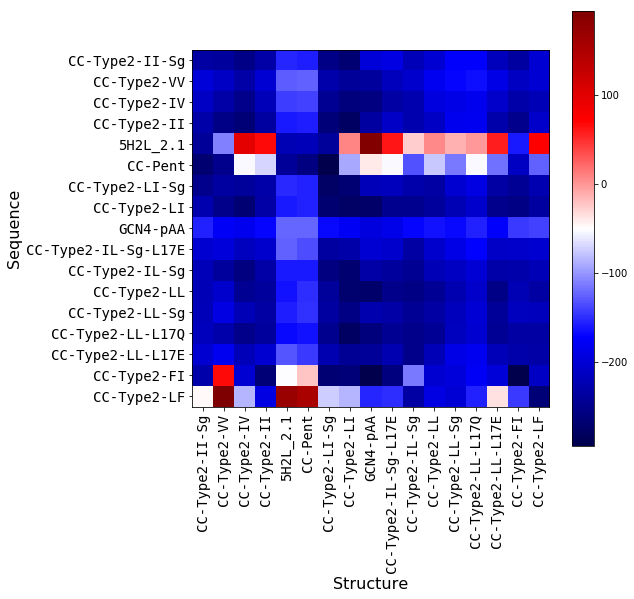

In [21]:
plot_im(total_results, 'total_results_final', labels=Legend_labels)

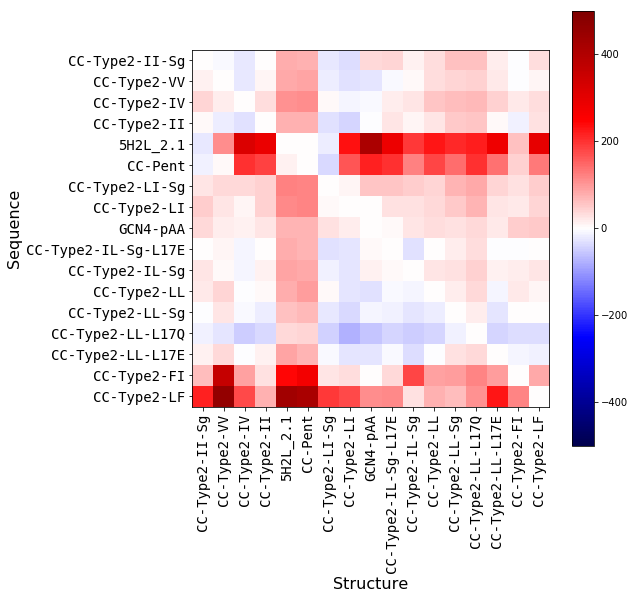

In [22]:
plot_im(normalised_results, 'normalised_results_final', labels=Legend_labels, vmin=-500, vmax=500)

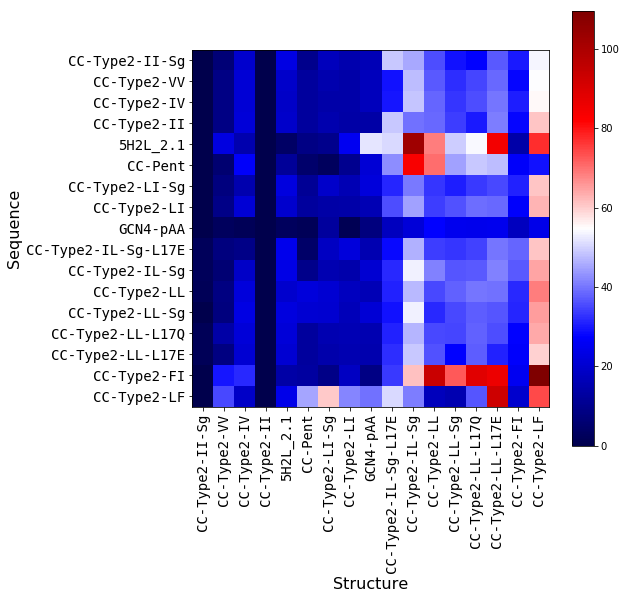

In [23]:
plot_im(total_std, 'total_std_final', labels=Legend_labels)

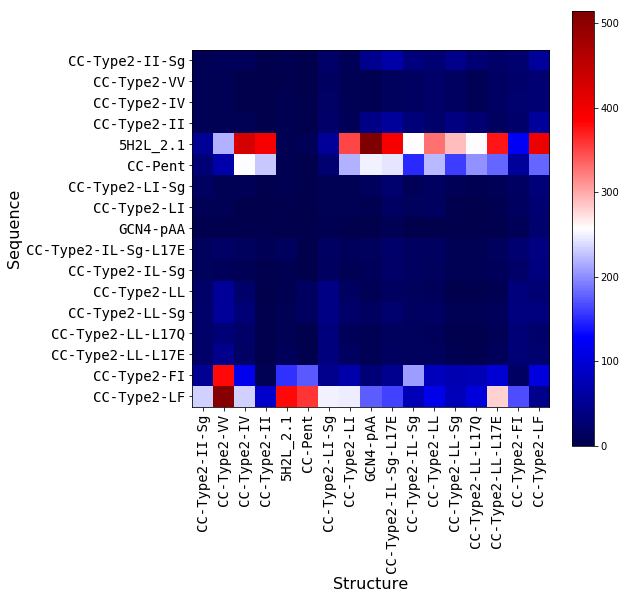

In [24]:
plot_im(steric_results, 'steric_results_final', labels=Legend_labels)

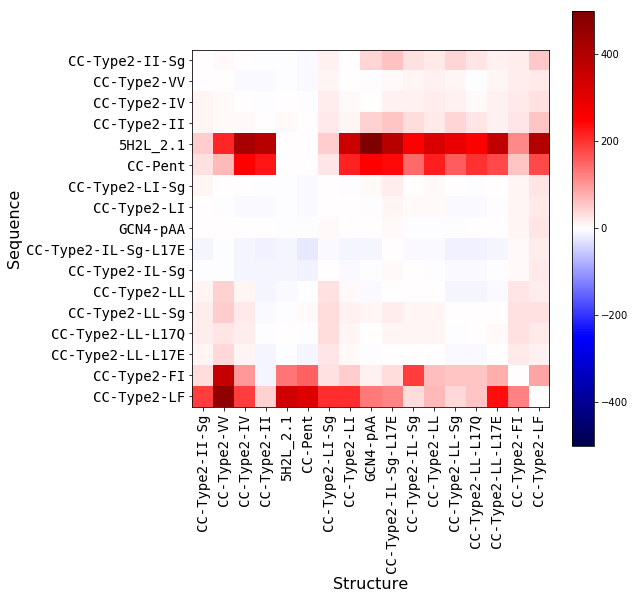

In [25]:
plot_im(normalised_sterics, 'normalised_sterics_final', labels=Legend_labels, vmin=-500, vmax=500)

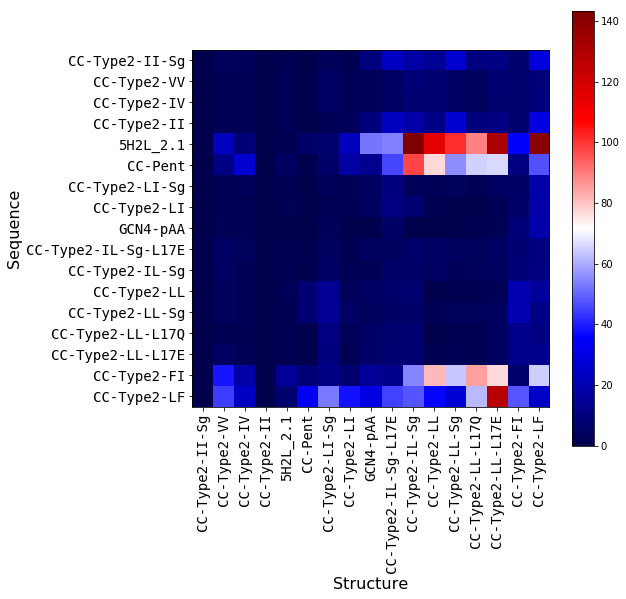

In [26]:
plot_im(steric_std, 'steric_std_final', labels=Legend_labels)

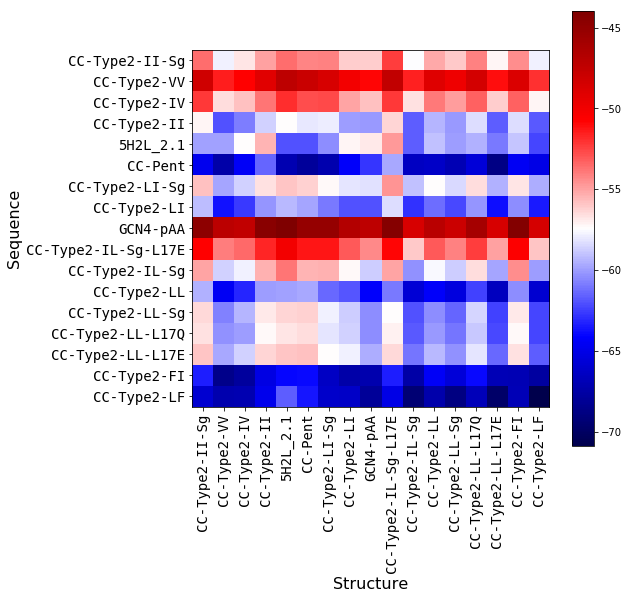

In [27]:
plot_im(total_defire, 'total_defire', labels=Legend_labels)

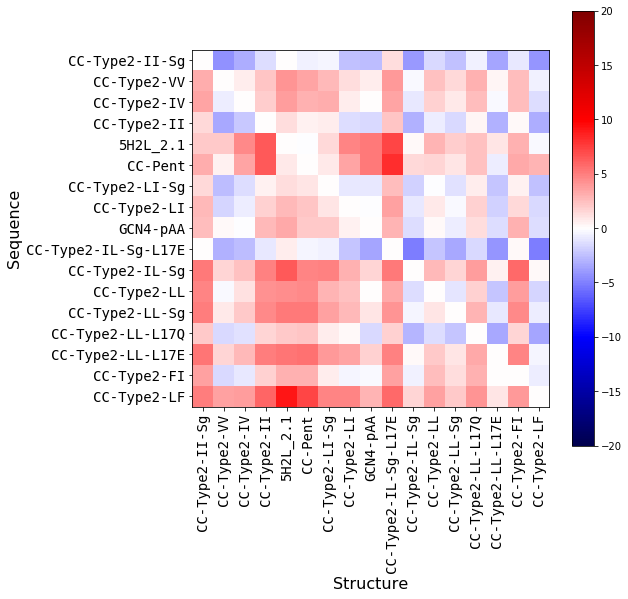

In [28]:
plot_im(normalised_defire, 'normalised_defire', labels=Legend_labels, vmin=-20, vmax=20)

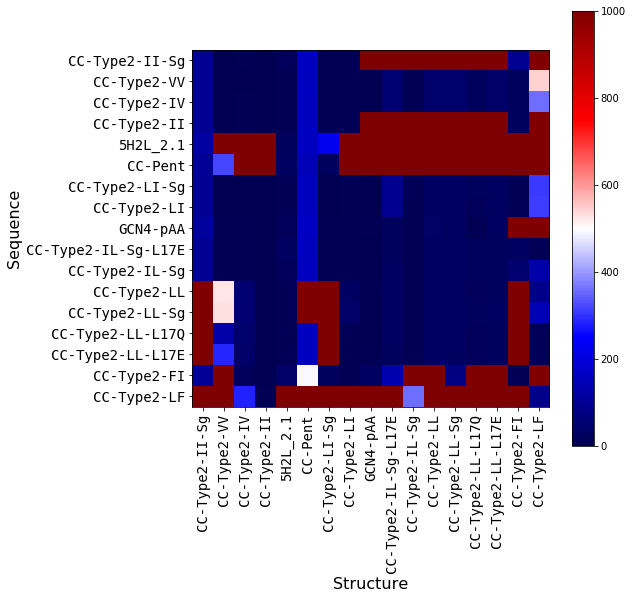

In [29]:
plot_im(total_amber, 'total_amber', labels=Legend_labels, vmin=0, vmax=1000)

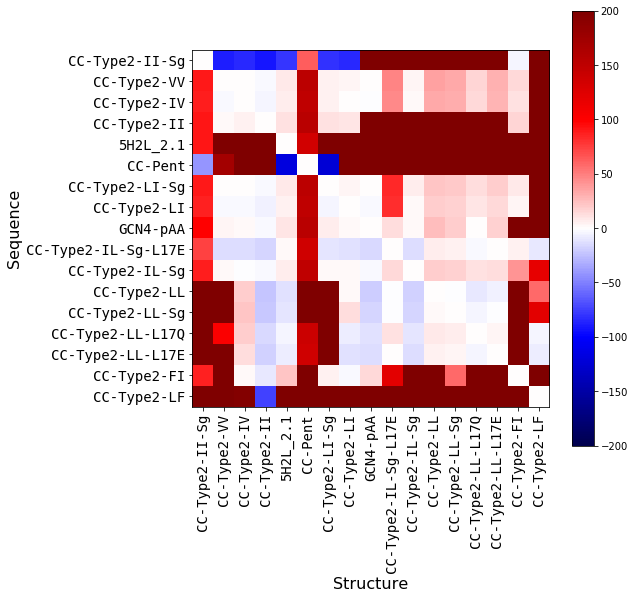

In [30]:
plot_im(normalised_amber, 'normalised_amber', labels=Legend_labels, vmin=-200, vmax=200)

In [31]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_im_2plots(array1, array2, title1=None, title2=None, savename=None, labels=None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(16,6))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                    )
    ax1 = grid[0]
    ax2 = grid[1]
    im1 = ax1.imshow(array1, interpolation='nearest', cmap='seismic', vmin=vmin, vmax=vmax)
    ax1.set_xticks(numpy.arange(0, len(all_sequences), 1.0))
    if labels == None:
        ax1.set_xticklabels(
            [seq[4:10] for seq in all_sequences],
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax1.set_yticklabels(
            [seq[4:10] for seq in all_sequences],
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    else:
        ax1.set_xticklabels(
            labels,
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax1.set_yticklabels(
            labels,
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    ax1.set_yticks(numpy.arange(0, len(all_sequences), 1.0))
    ax1.set_xlabel('Structure', fontdict={'size':16})
    ax1.set_ylabel('Sequence', fontdict={'size':16})
    
    im2 = ax2.imshow(array2, interpolation='nearest', cmap='seismic', vmin=vmin, vmax=vmax)
    ax2.set_xticks(numpy.arange(0, len(all_sequences), 1.0))
    if labels == None:
        ax2.set_xticklabels(
            [seq[4:10] for seq in all_sequences],
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax2.set_yticklabels(
            labels,
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    else:
        ax2.set_xticklabels(
            labels,
            rotation='vertical', fontdict={'family':'monospace', 'size':14})
        ax2.set_yticklabels(labels,
            rotation='horizontal', fontdict={'family':'monospace', 'size':14})
    ax2.set_yticks(numpy.arange(0, len(all_sequences), 1.0))
    ax2.set_xlabel('Structure', fontdict={'size':16})
    cbar = grid[1].cax.colorbar(im2)
    cbar.solids.set_edgecolor("face")
    if title1 == None:
        pass
    else:
        ax1.set_title(title1, fontdict={'size':16})
    if title2 == None:
        pass
    else:
        ax2.set_title(title2, fontdict={'size':16})
    if savename == None:
        pass
    else:
        fig.savefig(savename+'.svg', format='svg')
    return

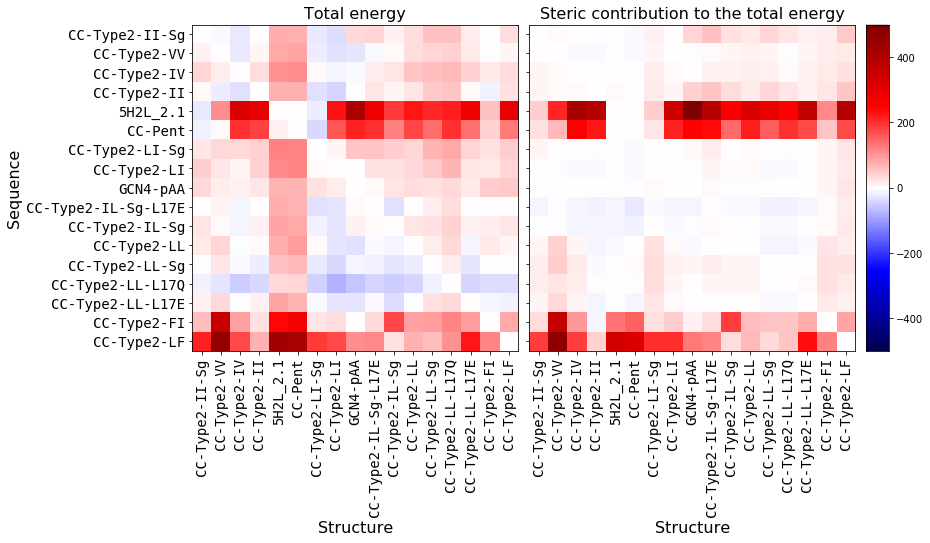

In [32]:
plot_im_2plots(normalised_results, normalised_sterics, savename='totalplussetrics_final', 
               title1='Total energy', title2='Steric contribution to the total energy', labels=Legend_labels, vmin=-500, vmax=500)